In [63]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

### Load Dataset

In [64]:
dftrain = pd.read_csv('train.csv')      #training data
dfeval = pd.read_csv('eval.csv')        #testing data
ytrain = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [65]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [66]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [67]:
dftrain.shape

(627, 9)

In [68]:
ytrain.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

<Axes: >

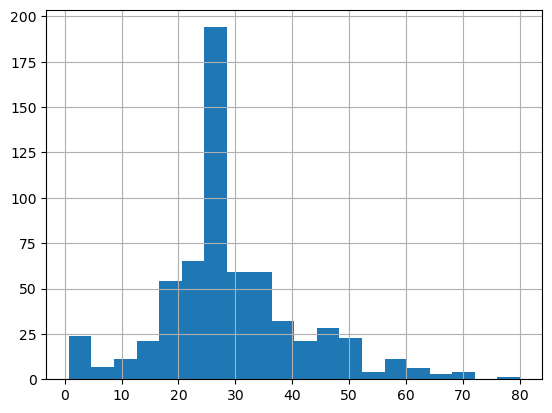

In [69]:
dftrain.age.hist(bins=20)

<Axes: ylabel='sex'>

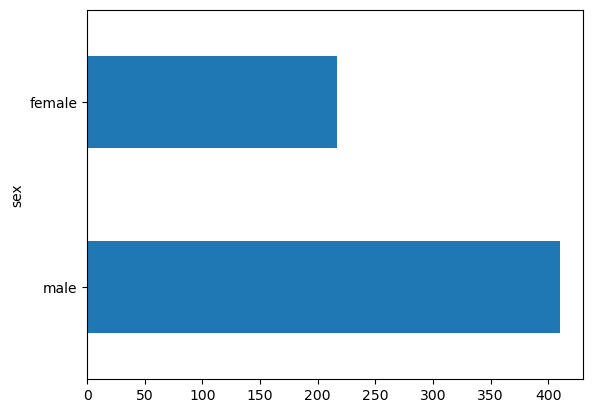

In [70]:
dftrain.sex.value_counts().plot(kind='barh')

<Axes: ylabel='class'>

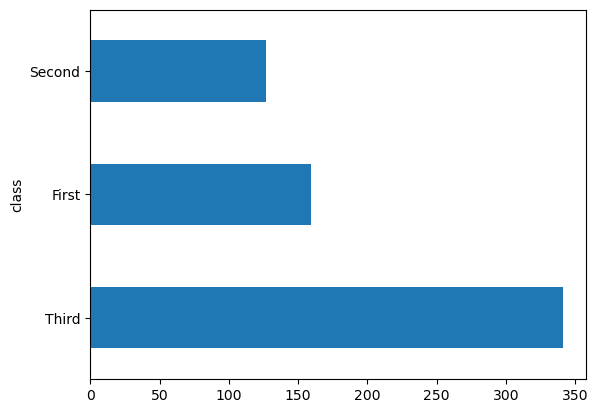

In [71]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% Survived')

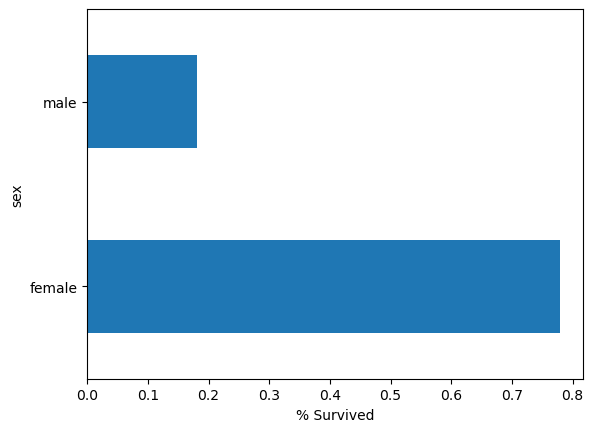

In [72]:
pd.concat([dftrain, ytrain], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% Survived')

In [73]:
dfeval.shape

(264, 9)

In [74]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']

NUMERICAL_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.sequence_categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERICAL_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_co

In [75]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        # Corrected: Use tf.data.Dataset instead of df.data.Dataset
        # Also fixed: use data_df instead of dict_df
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

train_input_fn = make_input_fn(dftrain, ytrain)
# Fixed: changed y_eval to yeval (assuming that's the correct variable name)
test_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

linear_est.train(train_input_fn)  # train
# Fixed: changed eval_input_fn to test_input_fn
result = linear_est.evaluate(test_input_fn)  # get model metrics/stats by testing on testing data

clear_output()  # clears console output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model
print(result)

0.7537879
{'accuracy': 0.7537879, 'accuracy_baseline': 0.625, 'auc': 0.8318029, 'auc_precision_recall': 0.7952436, 'average_loss': 0.47294226, 'label/mean': 0.375, 'loss': 0.46487787, 'precision': 0.68085104, 'prediction/mean': 0.37607723, 'recall': 0.64646465, 'global_step': 200}


In [81]:
result = list(linear_est.predict(test_input_fn))
print(dfeval.loc[4])
print(y_eval.loc[4])
print(result[4]['probabilities'][1])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\smkal\AppData\Local\Temp\tmpz94rvpp8\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
sex                          male
age                          34.0
n_siblings_spouses              0
parch                           0
fare                         13.0
class                      Second
deck                            D
embark_town           Southampton
alone                           y
Name: 4, dtype: object
1
0.27976695
